In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [5]:
from funcs_var import *

---

### Data Collection

#### short term interest rate

In [6]:
stir = pd.read_csv('var/short_term_int_rate_m.csv')

In [7]:
stir = stir[['TIME', 'Value']].copy()

#### inflation rate

In [8]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')

In [9]:
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()

In [10]:
ir = ir[:-9]

In [11]:
ir = [float(ir[i]) for i in range(len(ir))]

In [12]:
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))

In [13]:
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

#### unemployment rate

In [14]:
ur = pd.read_csv('var/unemployment_rate_m.csv')

In [15]:
ur = ur[['TIME', 'Value']].copy()

#### Make full df

In [16]:
ur[ur['TIME']=='1964-06']

,TIME,Value
113,1964-06,5.2


In [17]:
ir[ir['TIME']=='1964-6']

,TIME,Value
605,1964-6,1.3


In [18]:
stir.head()

,TIME,Value
0,1964-06,3.86
1,1964-07,3.87
2,1964-08,3.85
3,1964-09,3.87
4,1964-10,3.94


In [19]:
df_var = pd.concat([stir, 
           pd.DataFrame(ir.iloc[605:, 1]).reset_index(drop=True), 
           pd.DataFrame(ur.iloc[113:, 1]).reset_index(drop=True)], 
          axis=1)
df_var.columns = ['TIME','stir', 'infr', 'umpr']

---

### Stationarity part

In [20]:
df_var.head()

,TIME,stir,infr,umpr
0,1964-06,3.86,1.3,5.2
1,1964-07,3.87,1.3,4.9
2,1964-08,3.85,1,5.0
3,1964-09,3.87,1.3,5.1
4,1964-10,3.94,1,5.1


In [21]:
df_var = df_var.iloc[:-5, :].copy()

In [22]:
df_var_t = df_var.copy()
df_var_t['TIME'] = pd.to_datetime(df_var_t['TIME'])
df_var_t.index = df_var_t['TIME']

Results of Dickey-Fuller Test:
Test Statistic                  -2.169757
p-value                          0.217404
#Lags Used                      19.000000
Number of Observations Used    609.000000
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
Critical Value (10%)            -2.569304
dtype: float64


Results of KPSS Test:
Test Statistic            1.542907
p-value                   0.010000
#Lags Used               20.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


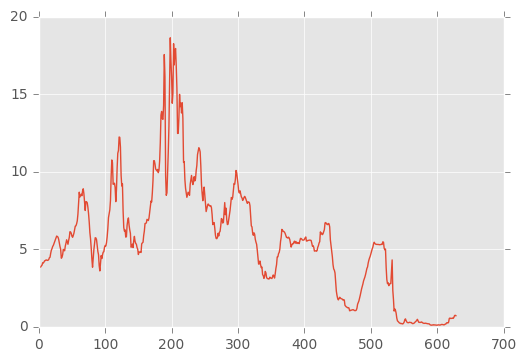

In [23]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.026327
p-value                          0.032508
#Lags Used                      18.000000
Number of Observations Used    610.000000
Critical Value (1%)             -3.441116
Critical Value (5%)             -2.866290
Critical Value (10%)            -2.569300
dtype: float64


Results of KPSS Test:
Test Statistic            1.154627
p-value                   0.010000
#Lags Used               20.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


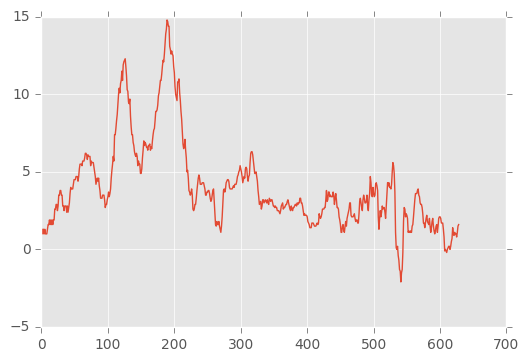

In [24]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.355673
p-value                          0.012566
#Lags Used                       6.000000
Number of Observations Used    622.000000
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
Critical Value (10%)            -2.569251
dtype: float64


Results of KPSS Test:
Test Statistic            0.24785
p-value                   0.10000
#Lags Used               20.00000
Critical Value (1%)       0.73900
Critical Value (2.5%)     0.57400
Critical Value (5%)       0.46300
Critical Value (10%)      0.34700
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


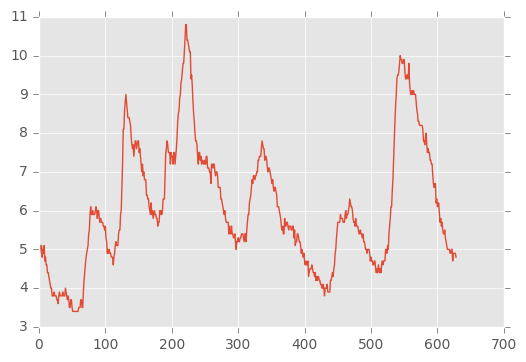

In [25]:
test_stationarity(df_var_t['umpr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                  -5.337747
p-value                          0.000005
#Lags Used                      18.000000
Number of Observations Used    609.000000
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
Critical Value (10%)            -2.569304
dtype: float64


Results of KPSS Test:
Test Statistic            0.082104
p-value                   0.100000
#Lags Used               19.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


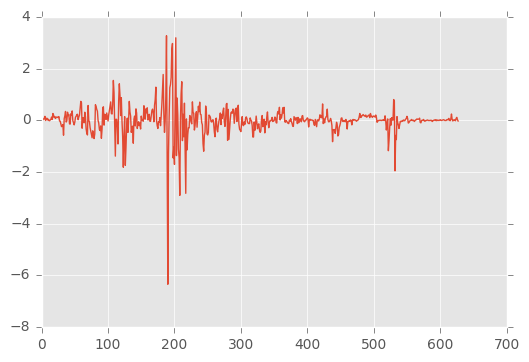

In [26]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -6.032762e+00
p-value                        1.405130e-07
#Lags Used                     1.400000e+01
Number of Observations Used    6.130000e+02
Critical Value (1%)           -3.441063e+00
Critical Value (5%)           -2.866266e+00
Critical Value (10%)          -2.569287e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.070892
p-value                   0.100000
#Lags Used               19.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


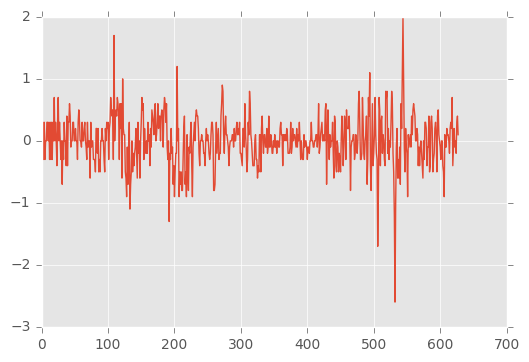

In [27]:
test_stationarity(diff_series(df_var_t['infr']))

Results of Dickey-Fuller Test:
Test Statistic                -5.880016e+00
p-value                        3.094187e-07
#Lags Used                     1.100000e+01
Number of Observations Used    6.160000e+02
Critical Value (1%)           -3.441010e+00
Critical Value (5%)           -2.866243e+00
Critical Value (10%)          -2.569275e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.055131
p-value                   0.100000
#Lags Used               19.000000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


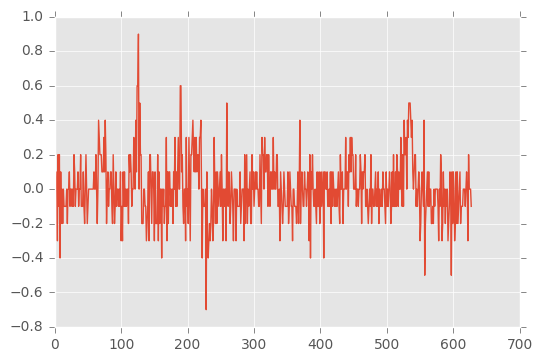

In [28]:
test_stationarity(diff_series(df_var_t['umpr']))

In [29]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [30]:
LAG = 4

In [31]:
STEPS = 8

In [32]:
train = df_var_t_diff.iloc[:-STEPS, 1:]
test = df_var_t_diff.iloc[-STEPS:, 1:]

train_real = df_var_t.iloc[:-STEPS, 1:]
test_real = df_var_t.iloc[-STEPS:, 1:]

### VAR

In [33]:
def var_model(train, steps, lags, years=None):
    df = np.array(train)
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [34]:
#years=train['TIME'][2:-6].reset_index(drop=True)
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:])

In [35]:
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mse': 0.0040194621438700276, 'rmse': 0.063399228259262169, 'mae': 0.0514231071974618}
{'mse': 0.050006438655736368, 'rmse': 0.22362119455842366, 'mae': 0.18022812493525364}
{'mse': 0.019131343941774893, 'rmse': 0.13831610152753326, 'mae': 0.093302842499049507}


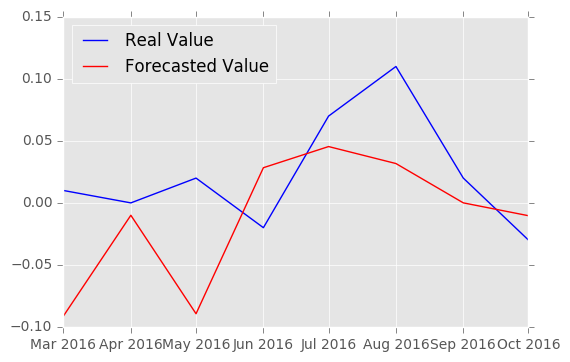

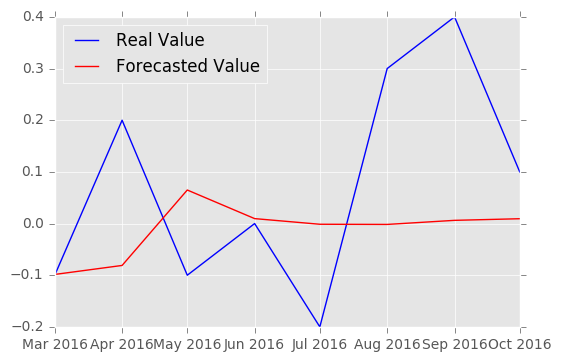

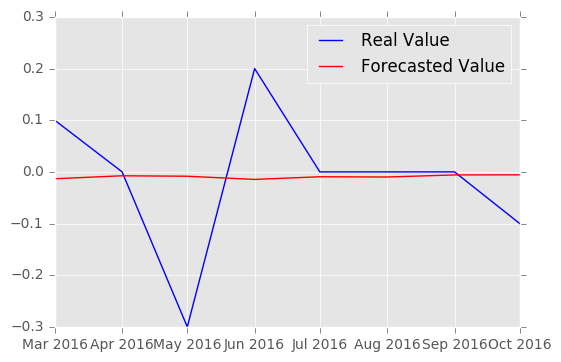

In [36]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])

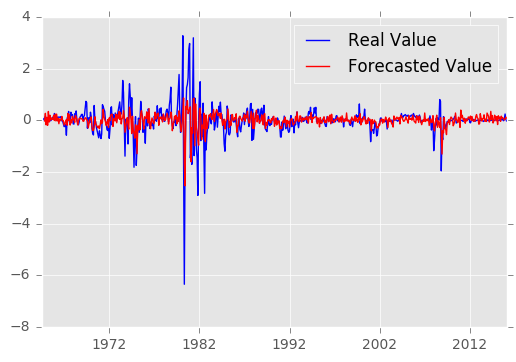

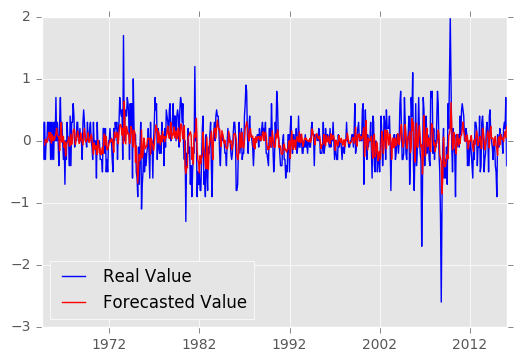

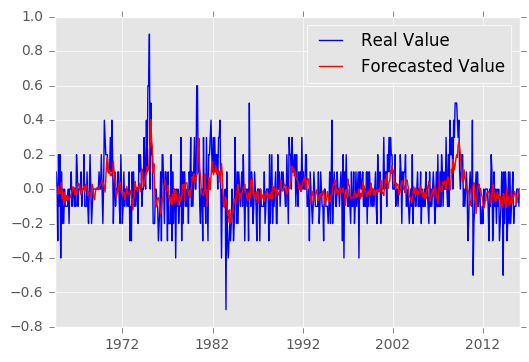

In [37]:
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

In [38]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])

In [39]:
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])

In [40]:
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))

{'mse': 0.04725396853351109, 'rmse': 0.21737977949549744, 'mae': 0.20588712725438912}
{'mse': 0.12454496836689739, 'rmse': 0.35290929198151949, 'mae': 0.26212172661295841}
{'mse': 0.0088393545904361763, 'rmse': 0.094017841872892277, 'mae': 0.082397376951637291}


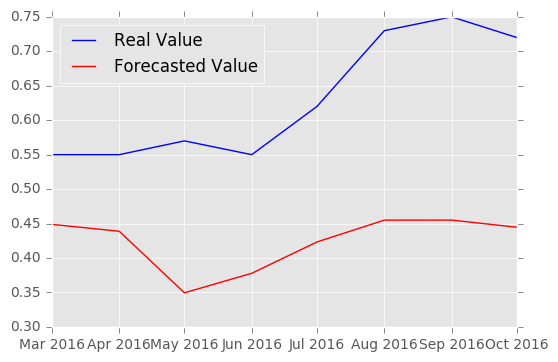

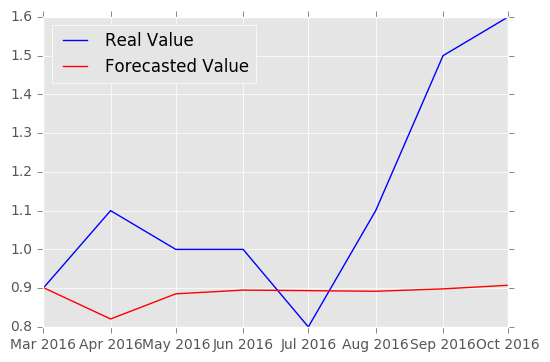

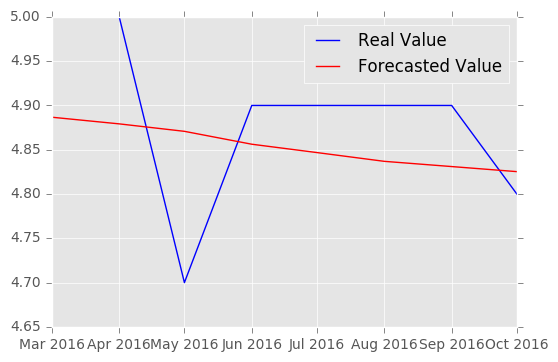

In [41]:
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])

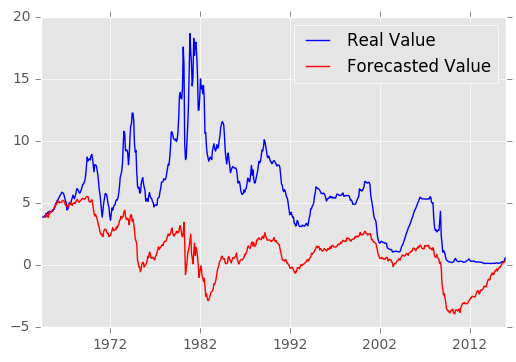

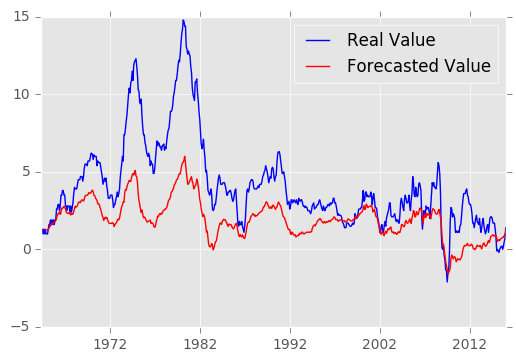

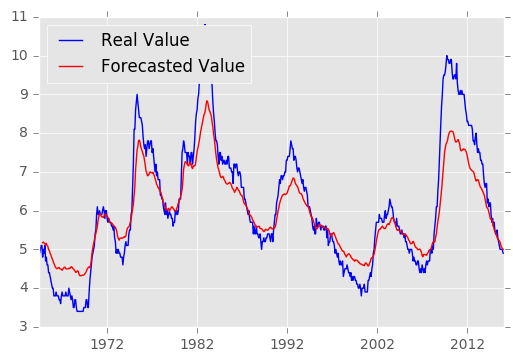

In [42]:
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

### ANN

In [43]:
df_nn = nn_transform(train, n=LAG)

In [44]:
train_nn_x = df_nn.iloc[:, 3:].copy()
train_nn_y = df_nn.iloc[:, :3].copy()

Первый запуск модели для проверки ее устойчивости

In [45]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [46]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100):
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
2s - loss: 0.1745
Epoch 2/100
1s - loss: 0.1669
Epoch 3/100
1s - loss: 0.1643
Epoch 4/100
1s - loss: 0.1610
Epoch 5/100
1s - loss: 0.1580
Epoch 6/100
1s - loss: 0.1545
Epoch 7/100
1s - loss: 0.1524
Epoch 8/100
1s - loss: 0.1492
Epoch 9/100
1s - loss: 0.1469
Epoch 10/100
1s - loss: 0.1453
Epoch 11/100
1s - loss: 0.1438
Epoch 12/100
1s - loss: 0.1424
Epoch 13/100
1s - loss: 0.1417
Epoch 14/100
1s - loss: 0.1417
Epoch 15/100
1s - loss: 0.1407
Epoch 16/100
1s - loss: 0.1396
Epoch 17/100
1s - loss: 0.1390
Epoch 18/100
1s - loss: 0.1387
Epoch 19/100
1s - loss: 0.1388
Epoch 20/100
1s - loss: 0.1382
Epoch 21/100
1s - loss: 0.1375
Epoch 22/100
1s - loss: 0.1381
Epoch 23/100
1s - loss: 0.1381
Epoch 24/100
1s - loss: 0.1369
Epoch 25/100
1s - loss: 0.1378
Epoch 26/100
1s - loss: 0.1381
Epoch 27/100
1s - loss: 0.1369
Epoch 28/100
1s - loss: 0.1371
Epoch 29/100
1s - loss: 0.1368
Epoch 30/100
1s - loss: 0.1371
Epoch 31/100
1s - loss: 0.1369
Epoch 32/100
1s - loss: 0.1364
Epoch 33/100
1s -

In [48]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'mse': 0.0081351252323795878, 'rmse': 0.090194929083511052, 'mae': 0.077136795520782481}
{'mse': 0.043662129740329021, 'rmse': 0.20895485096146732, 'mae': 0.17193637983873489}
{'mse': 0.017159798571301853, 'rmse': 0.13099541431402037, 'mae': 0.097152846492826961}


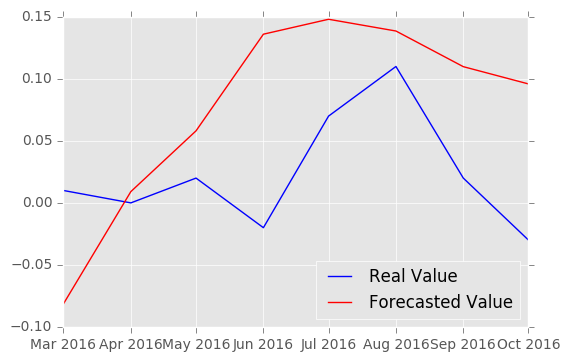

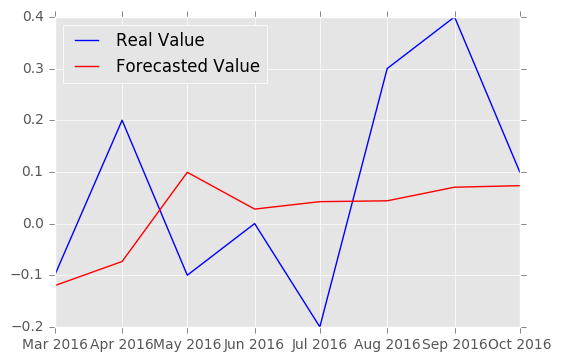

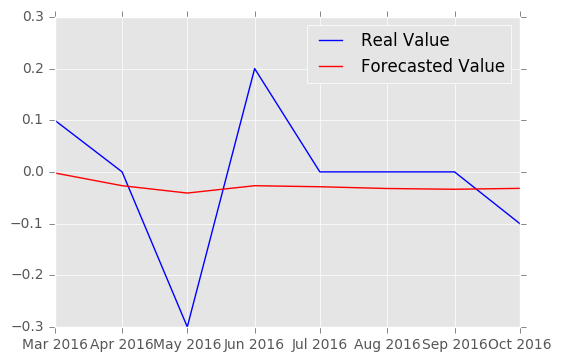

In [49]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])

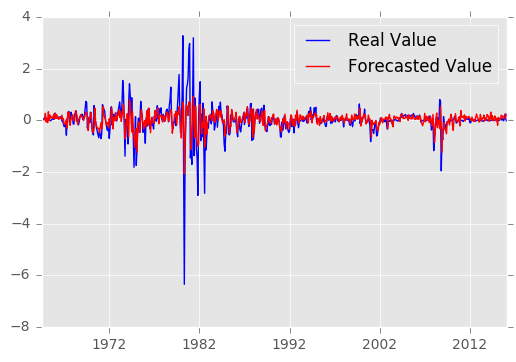

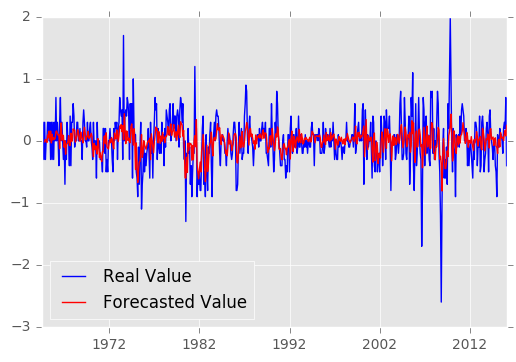

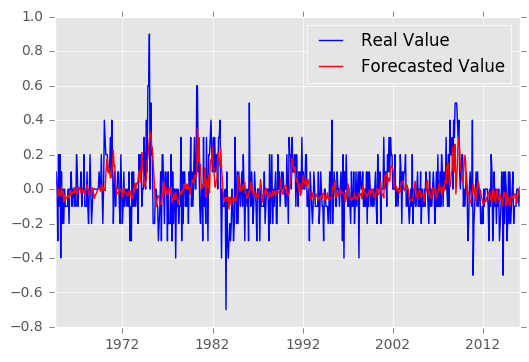

In [50]:
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

In [51]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))

{'mse': 0.049651769665116537, 'rmse': 0.22282677053064459, 'mae': 0.18512171752750878}
{'mse': 0.061920090534289506, 'rmse': 0.24883747815449647, 'mae': 0.19702511206269269}
{'mse': 0.018169347640070967, 'rmse': 0.13479372255439409, 'mae': 0.13177900332957493}


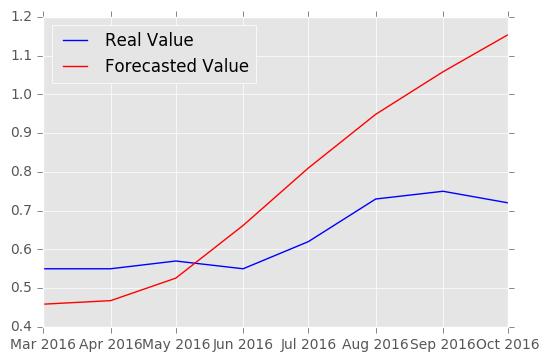

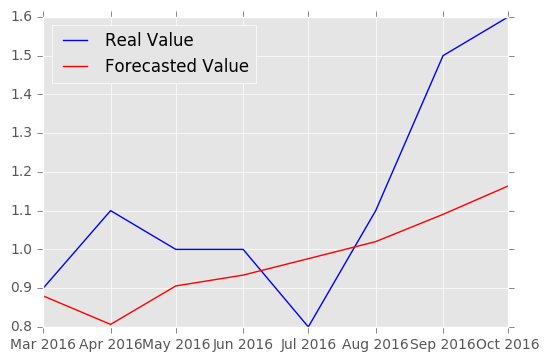

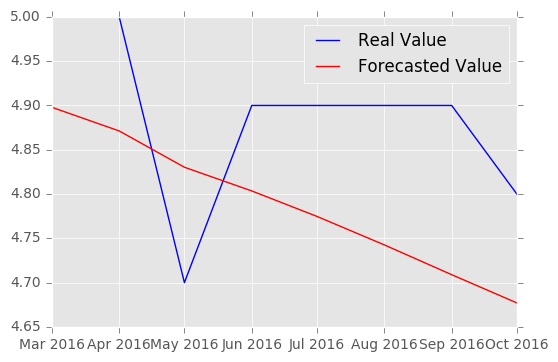

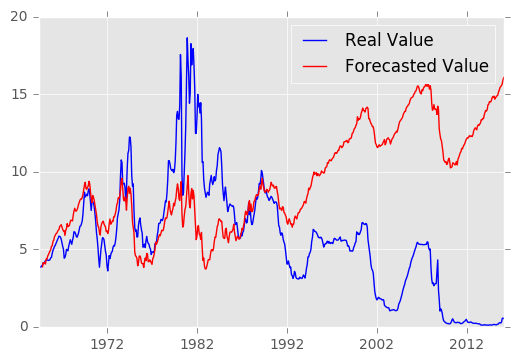

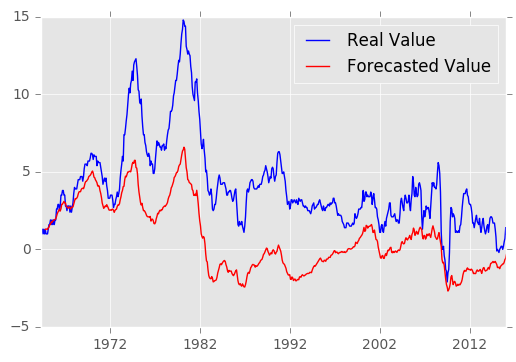

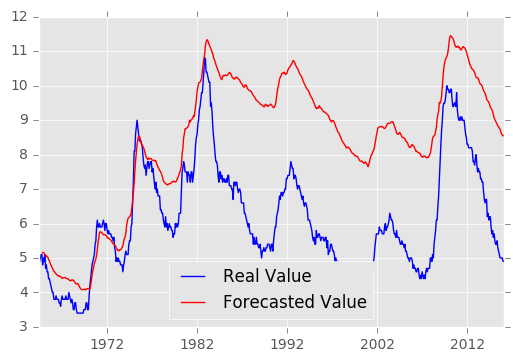

In [52]:
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск модели

In [53]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [54]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
1s - loss: 0.1768
Epoch 2/100
1s - loss: 0.1679
Epoch 3/100
1s - loss: 0.1635
Epoch 4/100
1s - loss: 0.1602
Epoch 5/100
1s - loss: 0.1558
Epoch 6/100
1s - loss: 0.1525
Epoch 7/100
1s - loss: 0.1502
Epoch 8/100
1s - loss: 0.1477
Epoch 9/100
1s - loss: 0.1459
Epoch 10/100
1s - loss: 0.1448
Epoch 11/100
1s - loss: 0.1429
Epoch 12/100
1s - loss: 0.1417
Epoch 13/100
1s - loss: 0.1413
Epoch 14/100
1s - loss: 0.1406
Epoch 15/100
1s - loss: 0.1400
Epoch 16/100
1s - loss: 0.1397
Epoch 17/100
1s - loss: 0.1388
Epoch 18/100
1s - loss: 0.1385
Epoch 19/100
1s - loss: 0.1376
Epoch 20/100
1s - loss: 0.1372
Epoch 21/100
1s - loss: 0.1371
Epoch 22/100
1s - loss: 0.1366
Epoch 23/100
1s - loss: 0.1371
Epoch 24/100
1s - loss: 0.1372
Epoch 25/100
1s - loss: 0.1365
Epoch 26/100
1s - loss: 0.1364
Epoch 27/100
1s - loss: 0.1361
Epoch 28/100
1s - loss: 0.1358
Epoch 29/100
1s - loss: 0.1350
Epoch 30/100
1s - loss: 0.1351
Epoch 31/100
1s - loss: 0.1354
Epoch 32/100
1s - loss: 0.1353
Epoch 33/100
1s -

In [55]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'mse': 0.0051500166646540153, 'rmse': 0.071763616580088938, 'mae': 0.055296067353337974}
{'mse': 0.041831359222995586, 'rmse': 0.20452716011081654, 'mae': 0.17558868750929832}
{'mse': 0.021073320282228403, 'rmse': 0.14516652603898877, 'mae': 0.11218185219913723}


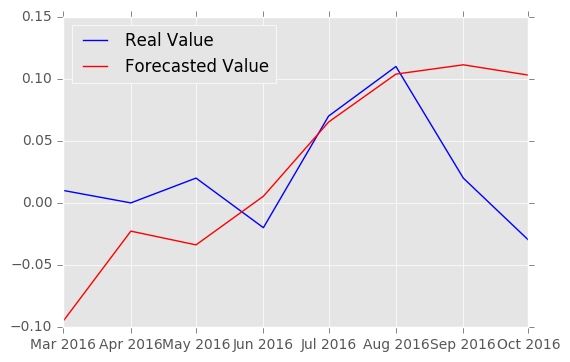

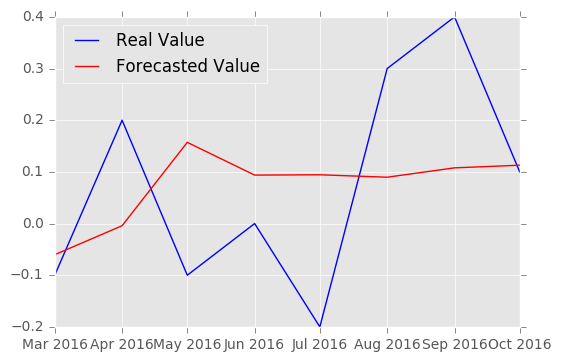

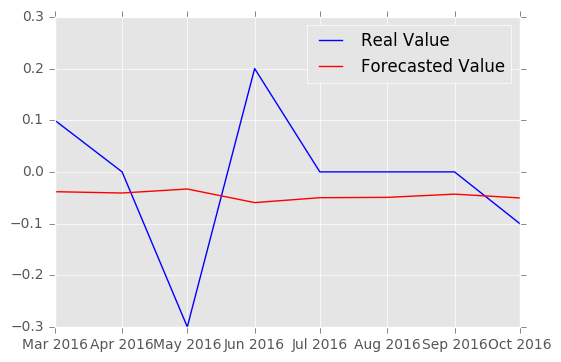

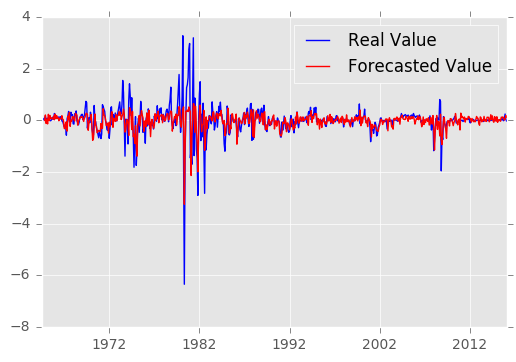

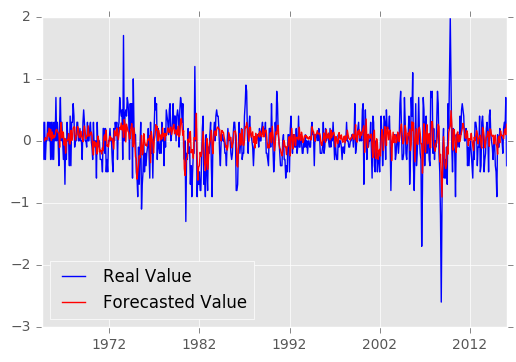

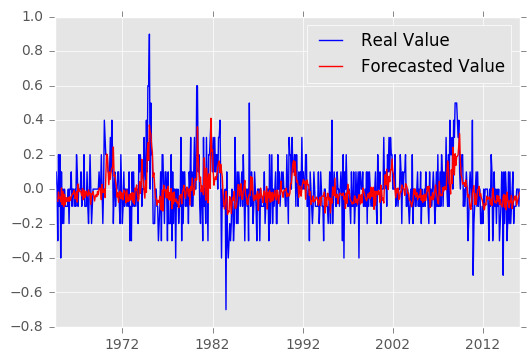

In [56]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

{'mse': 0.018474061653278612, 'rmse': 0.13591932038263954, 'mae': 0.12904025249183176}
{'mse': 0.047139233710865286, 'rmse': 0.21711571502511118, 'mae': 0.15814773105084895}
{'mse': 0.047450866213669091, 'rmse': 0.21783219737602863, 'mae': 0.20602412372827517}


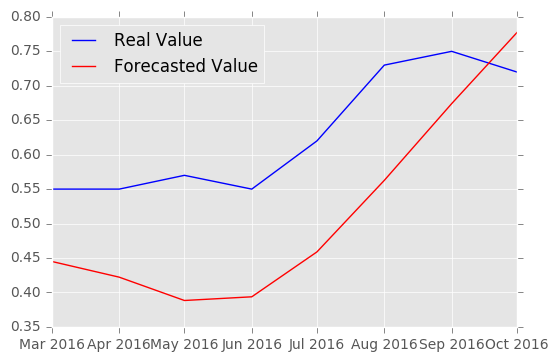

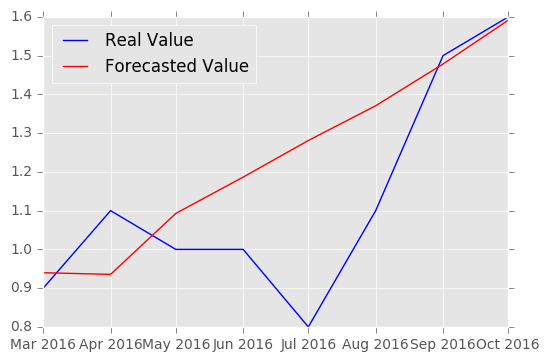

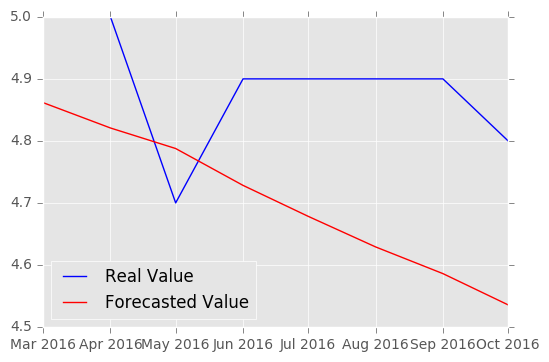

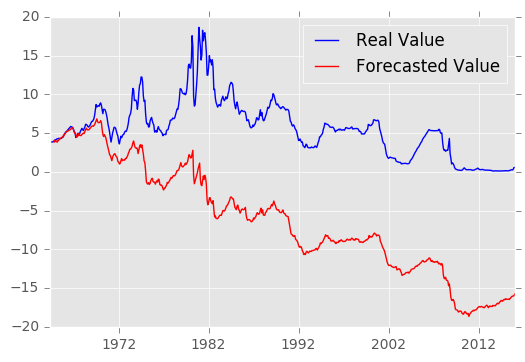

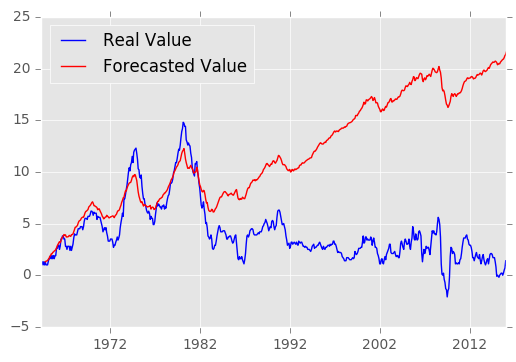

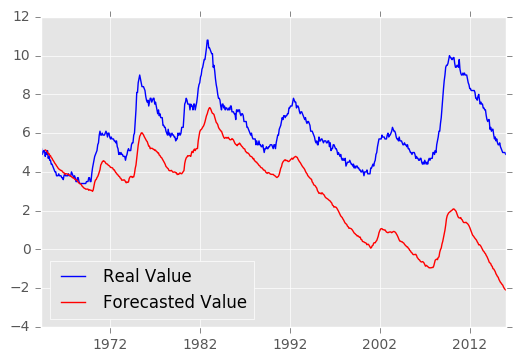

In [57]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

### Hybrid

In [58]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    train_nn_x = df_nn.iloc[:, n_feat:].copy()
    train_nn_y = df_nn.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    
    hybrid_result = pd.DataFrame(var_result + nn_result.as_matrix())
    hybrid_result.columns = train.columns
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(1, steps+1)]
        hybrid_result.index = ind
    return hybrid_result

In [59]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [60]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.1937
Epoch 2/10
1s - loss: 0.1383
Epoch 3/10
1s - loss: 0.1384
Epoch 4/10
1s - loss: 0.1379
Epoch 5/10
1s - loss: 0.1388
Epoch 6/10
1s - loss: 0.1384
Epoch 7/10
1s - loss: 0.1385
Epoch 8/10
1s - loss: 0.1385
Epoch 9/10
1s - loss: 0.1386
Epoch 10/10
1s - loss: 0.1384


Первый запуск

In [61]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mse': 0.012798969982092782, 'rmse': 0.11313253281922395, 'mae': 0.10228907429014852}
{'mse': 0.054515263887790807, 'rmse': 0.23348503996571346, 'mae': 0.1909367717315183}
{'mse': 0.019358912306292921, 'rmse': 0.13913630836806373, 'mae': 0.090597621297010017}


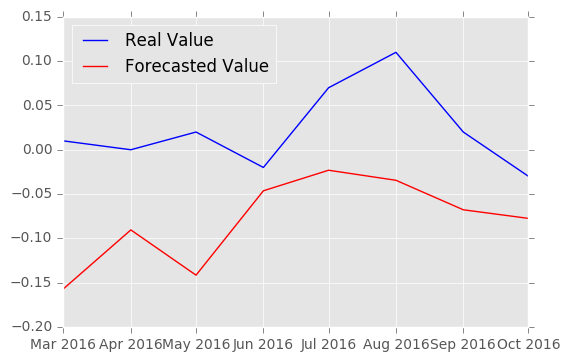

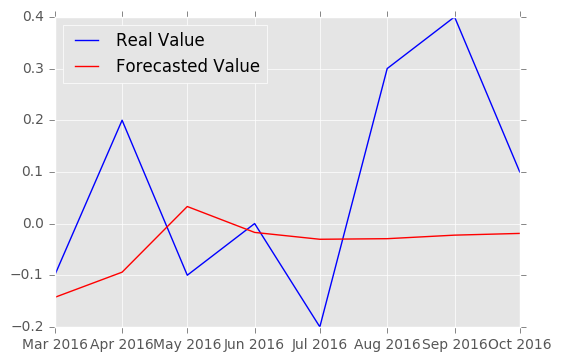

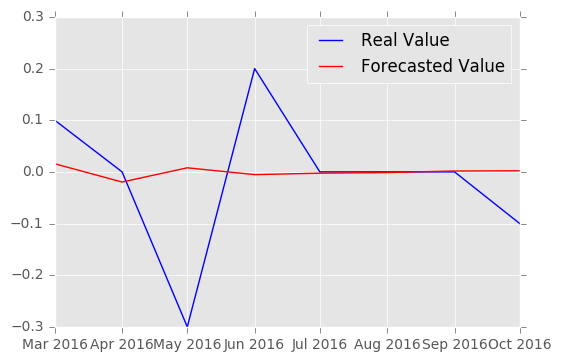

In [62]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 0.31107298573278303, 'rmse': 0.55773917356841896, 'mae': 0.51246371265151336}
{'mse': 0.23120326135420752, 'rmse': 0.48083600255618081, 'mae': 0.37038056683169596}
{'mse': 0.008665189957183083, 'rmse': 0.09308700208505527, 'mae': 0.063060628083410286}


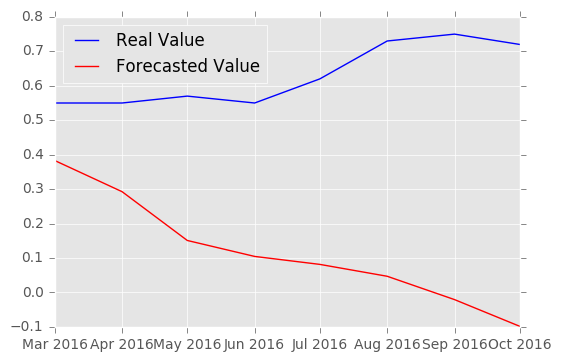

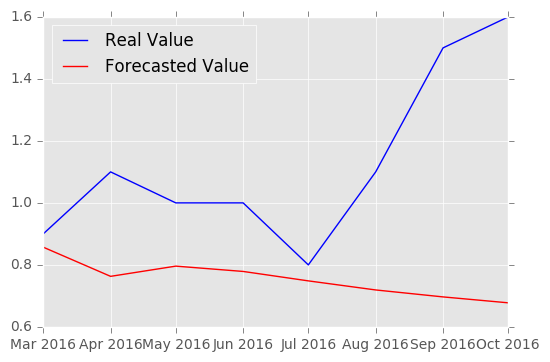

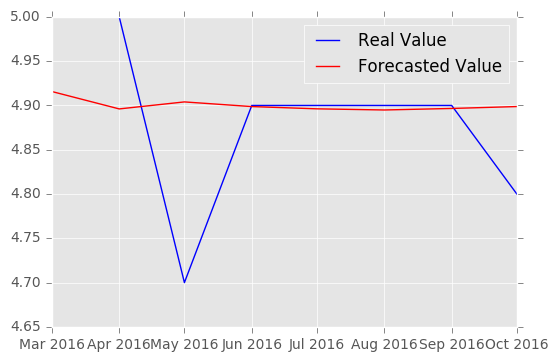

In [63]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.1623
Epoch 2/10
1s - loss: 0.1392
Epoch 3/10
1s - loss: 0.1391
Epoch 4/10
1s - loss: 0.1388
Epoch 5/10
1s - loss: 0.1393
Epoch 6/10
1s - loss: 0.1386
Epoch 7/10
1s - loss: 0.1379
Epoch 8/10
1s - loss: 0.1387
Epoch 9/10
1s - loss: 0.1382
Epoch 10/10
1s - loss: 0.1385


In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mse': 0.0036486545551613426, 'rmse': 0.060404093860940769, 'mae': 0.050810862256167599}
{'mse': 0.044377344620714396, 'rmse': 0.21065930936161922, 'mae': 0.18011353407435038}
{'mse': 0.01948841279500408, 'rmse': 0.13960090542329617, 'mae': 0.090645407861119479}


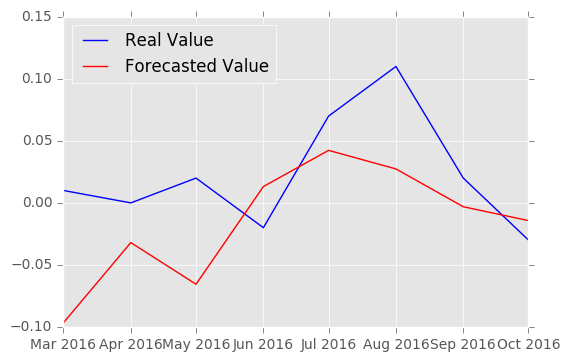

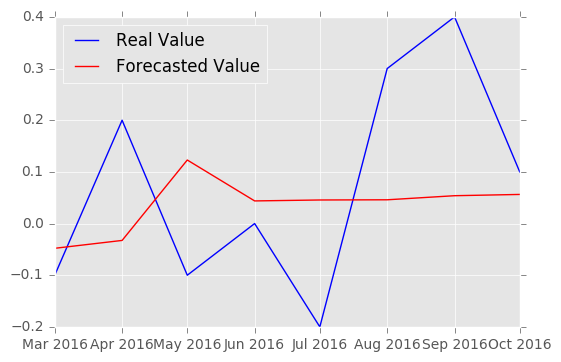

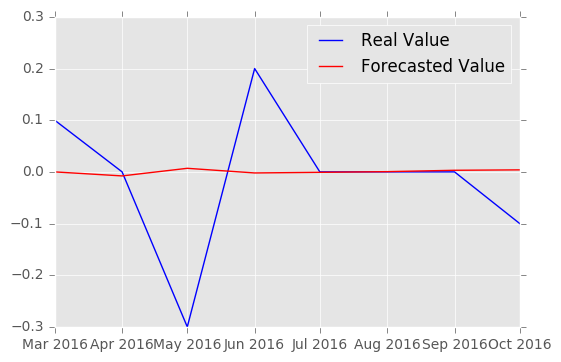

In [66]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 0.057067731658945929, 'rmse': 0.23888853396290483, 'mae': 0.22671110793598731}
{'mse': 0.041246707477651898, 'rmse': 0.2030928543244491, 'mae': 0.16889483902936736}
{'mse': 0.0090078637147532285, 'rmse': 0.094909766171628662, 'mae': 0.065116083082618736}


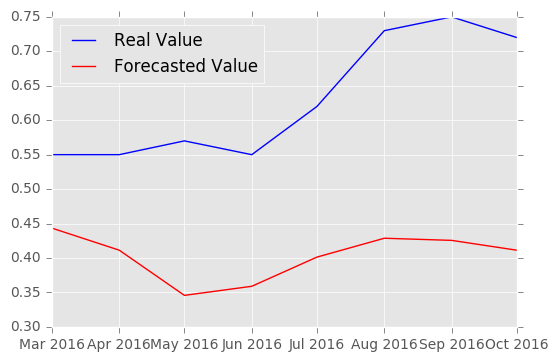

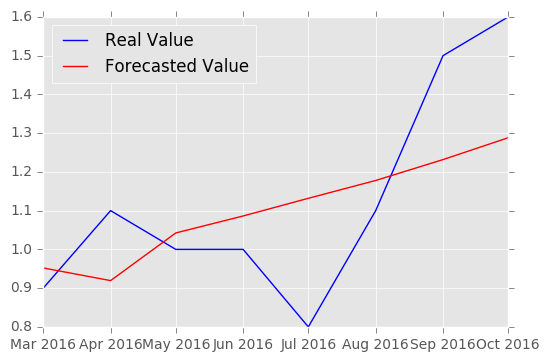

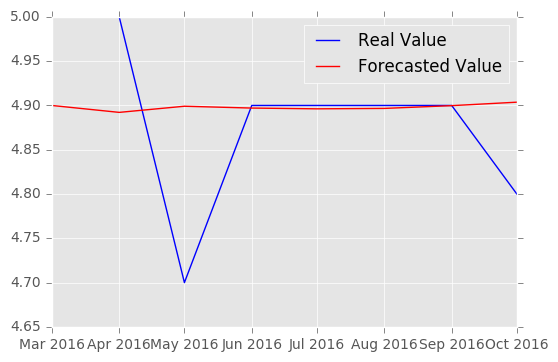

In [67]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.2809
Epoch 2/10
1s - loss: 0.1740
Epoch 3/10
1s - loss: 0.1532
Epoch 4/10
1s - loss: 0.1420
Epoch 5/10
1s - loss: 0.1416
Epoch 6/10
1s - loss: 0.1401
Epoch 7/10
1s - loss: 0.1394
Epoch 8/10
1s - loss: 0.1402
Epoch 9/10
1s - loss: 0.1383
Epoch 10/10
1s - loss: 0.1387


In [69]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mse': 0.003092881278401227, 'rmse': 0.055613678878502784, 'mae': 0.044285854065046558}
{'mse': 0.053601843775873889, 'rmse': 0.23152071997096477, 'mae': 0.18656343808180847}
{'mse': 0.019561899408470966, 'rmse': 0.13986386026587055, 'mae': 0.093054833312469665}


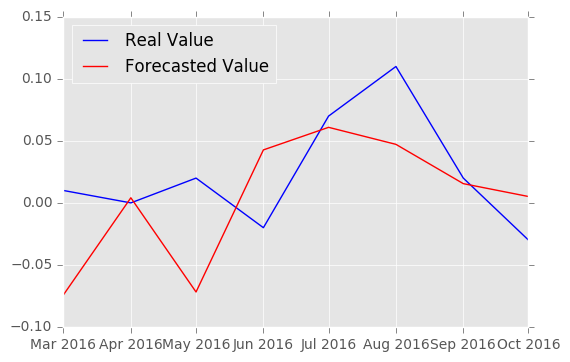

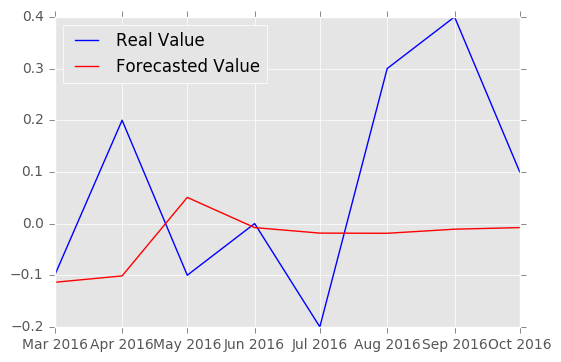

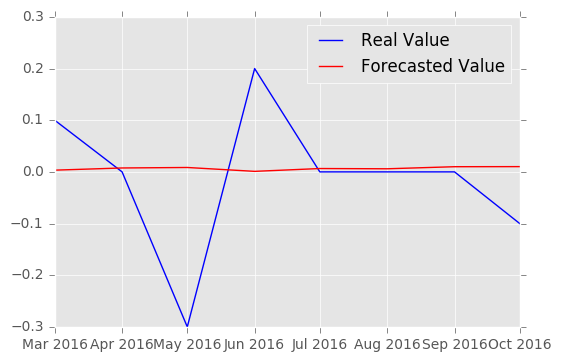

In [70]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mse': 0.019825008160506623, 'rmse': 0.14080130738209296, 'mae': 0.13499073829152416}
{'mse': 0.18211878558217143, 'rmse': 0.4267537762951506, 'mae': 0.31659115005900379}
{'mse': 0.011625685890774541, 'rmse': 0.10782247395962746, 'mae': 0.085241282409842745}


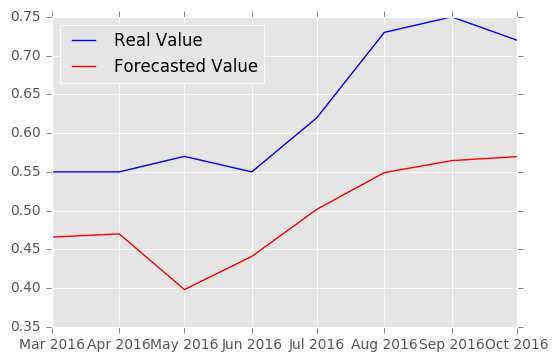

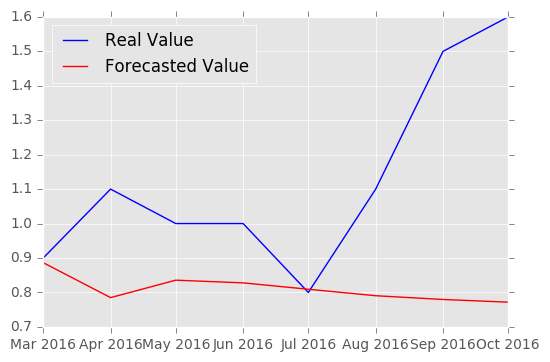

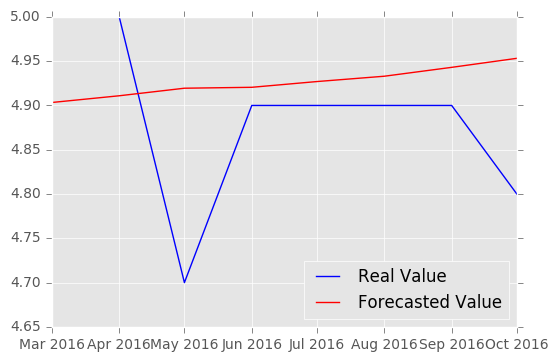

In [71]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

C DropOut 2

In [72]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
2s - loss: 0.3497
Epoch 2/10
1s - loss: 0.1880
Epoch 3/10
1s - loss: 0.1583
Epoch 4/10
1s - loss: 0.1498
Epoch 5/10
1s - loss: 0.1413
Epoch 6/10
1s - loss: 0.1411
Epoch 7/10
1s - loss: 0.1395
Epoch 8/10
1s - loss: 0.1383
Epoch 9/10
1s - loss: 0.1381
Epoch 10/10
1s - loss: 0.1384


{'mse': 0.059697672141302248, 'rmse': 0.24433107076526769, 'mae': 0.22981419093557437}
{'mse': 0.17516205249002265, 'rmse': 0.4185236582202046, 'mae': 0.31089818901532557}
{'mse': 0.010007212138651198, 'rmse': 0.10003605419373156, 'mae': 0.073380196168873146}


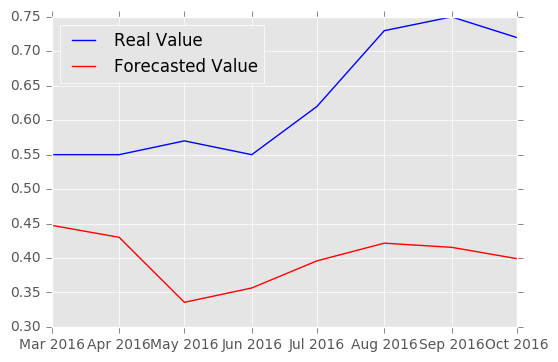

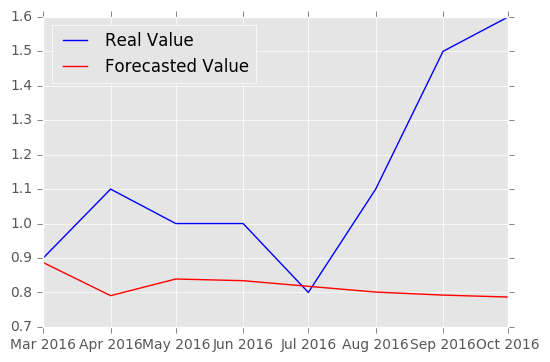

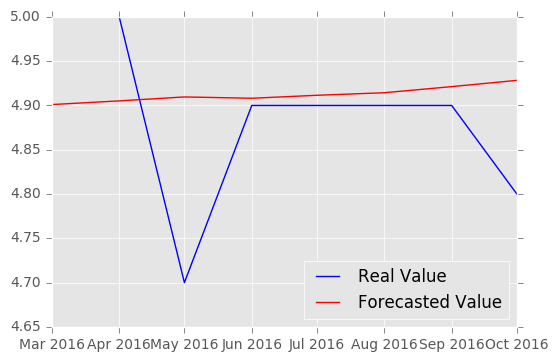

In [73]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid Full

In [74]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.7905
Epoch 2/500
1s - loss: 0.4207
Epoch 3/500
2s - loss: 0.2990
Epoch 4/500
2s - loss: 0.2503
Epoch 5/500
2s - loss: 0.2190
Epoch 6/500
2s - loss: 0.1935
Epoch 7/500
1s - loss: 0.1708
Epoch 8/500
1s - loss: 0.1460
Epoch 9/500
1s - loss: 0.1214
Epoch 10/500
1s - loss: 0.0979
Epoch 11/500
1s - loss: 0.0828
Epoch 12/500
1s - loss: 0.0742
Epoch 13/500
1s - loss: 0.0692
Epoch 14/500
1s - loss: 0.0662
Epoch 15/500
1s - loss: 0.0634
Epoch 16/500
1s - loss: 0.0613
Epoch 17/500
1s - loss: 0.0600
Epoch 18/500
1s - loss: 0.0586
Epoch 19/500
1s - loss: 0.0574
Epoch 20/500
1s - loss: 0.0557
Epoch 21/500
1s - loss: 0.0549
Epoch 22/500
1s - loss: 0.0545
Epoch 23/500
1s - loss: 0.0529
Epoch 24/500
1s - loss: 0.0524
Epoch 25/500
1s - loss: 0.0524
Epoch 26/500
1s - loss: 0.0511
Epoch 27/500
1s - loss: 0.0505
Epoch 28/500
1s - loss: 0.0495
Epoch 29/500
1s - loss: 0.0494
Epoch 30/500
1s - loss: 0.0489
Epoch 31/500
1s - loss: 0.0480
Epoch 32/500
1s - loss: 0.0481
Epoch 33/500
1s -

{'mse': 25.755345426092394, 'rmse': 5.0749724556979023, 'mae': 5.0703870902808283}
{'mse': 1.6899907221139809, 'rmse': 1.2999964315774029, 'mae': 1.2697118282479627}
{'mse': 0.011441185520748976, 'rmse': 0.10696347750867571, 'mae': 0.07711542204168742}


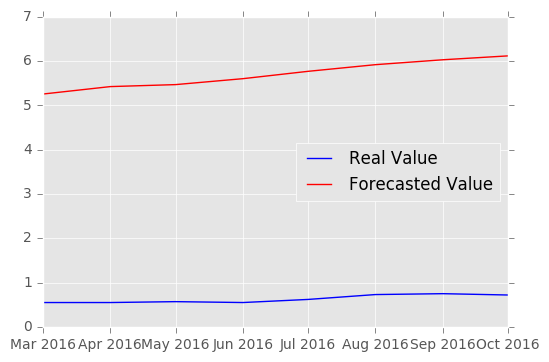

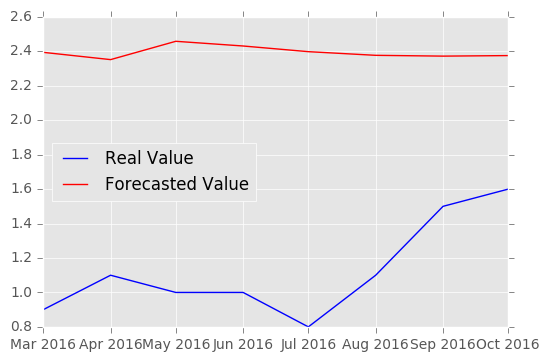

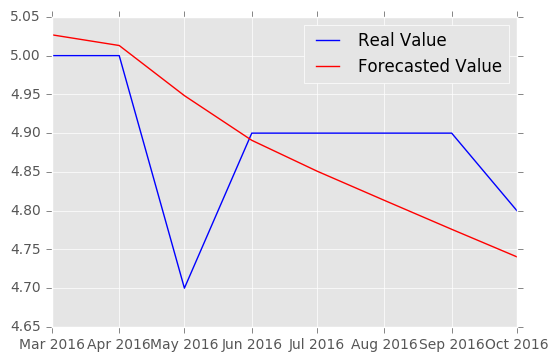

In [76]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [77]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.9061
Epoch 2/500
1s - loss: 0.4755
Epoch 3/500
1s - loss: 0.2949
Epoch 4/500
1s - loss: 0.2159
Epoch 5/500
1s - loss: 0.1640
Epoch 6/500
1s - loss: 0.1284
Epoch 7/500
1s - loss: 0.1057
Epoch 8/500
1s - loss: 0.0918
Epoch 9/500
1s - loss: 0.0830
Epoch 10/500
1s - loss: 0.0762
Epoch 11/500
1s - loss: 0.0714
Epoch 12/500
1s - loss: 0.0665
Epoch 13/500
1s - loss: 0.0636
Epoch 14/500
1s - loss: 0.0612
Epoch 15/500
1s - loss: 0.0590
Epoch 16/500
1s - loss: 0.0569
Epoch 17/500
1s - loss: 0.0557
Epoch 18/500
1s - loss: 0.0544
Epoch 19/500
1s - loss: 0.0529
Epoch 20/500
1s - loss: 0.0526
Epoch 21/500
1s - loss: 0.0504
Epoch 22/500
1s - loss: 0.0506
Epoch 23/500
1s - loss: 0.0495
Epoch 24/500
1s - loss: 0.0493
Epoch 25/500
1s - loss: 0.0484
Epoch 26/500
1s - loss: 0.0474
Epoch 27/500
1s - loss: 0.0476
Epoch 28/500
1s - loss: 0.0464
Epoch 29/500
1s - loss: 0.0467
Epoch 30/500
1s - loss: 0.0455
Epoch 31/500
1s - loss: 0.0449
Epoch 32/500
1s - loss: 0.0454
Epoch 33/500
1s -

{'mse': 17.967998856183115, 'rmse': 4.2388676384363686, 'mae': 4.2327431301040068}
{'mse': 1.3403777210198589, 'rmse': 1.1577468294147295, 'mae': 1.1225728448207712}
{'mse': 0.039451520759552508, 'rmse': 0.19862406893312931, 'mae': 0.17431631664800695}


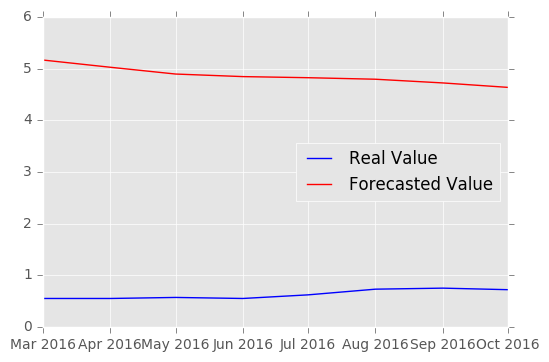

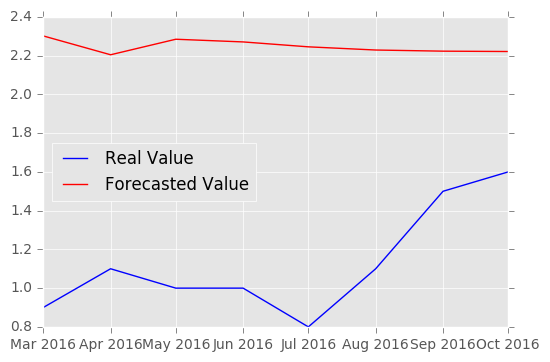

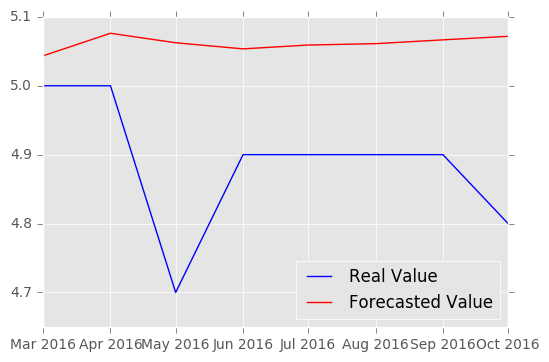

In [78]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [81]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 1.0408
Epoch 2/500
0s - loss: 0.9718
Epoch 3/500
0s - loss: 0.9176
Epoch 4/500
0s - loss: 0.8756
Epoch 5/500
0s - loss: 0.7945
Epoch 6/500
0s - loss: 0.7436
Epoch 7/500
0s - loss: 0.6962
Epoch 8/500
0s - loss: 0.6793
Epoch 9/500
0s - loss: 0.6573
Epoch 10/500
0s - loss: 0.6443
Epoch 11/500
0s - loss: 0.6208
Epoch 12/500
0s - loss: 0.6312
Epoch 13/500
0s - loss: 0.6138
Epoch 14/500
0s - loss: 0.6244
Epoch 15/500
1s - loss: 0.6029
Epoch 16/500
0s - loss: 0.5972
Epoch 17/500
0s - loss: 0.5824
Epoch 18/500
0s - loss: 0.5988
Epoch 19/500
0s - loss: 0.5859
Epoch 20/500
1s - loss: 0.5871
Epoch 21/500
1s - loss: 0.5802
Epoch 22/500
1s - loss: 0.5889
Epoch 23/500
1s - loss: 0.5875
Epoch 24/500
0s - loss: 0.5625
Epoch 25/500
0s - loss: 0.5701
Epoch 26/500
0s - loss: 0.5612
Epoch 27/500
0s - loss: 0.5849
Epoch 28/500
0s - loss: 0.5377
Epoch 29/500
0s - loss: 0.5197
Epoch 30/500
1s - loss: 0.5562
Epoch 31/500
1s - loss: 0.5117
Epoch 32/500
1s - loss: 0.5408
Epoch 33/500
1s -

{'mse': 9.3102085437873452, 'rmse': 3.0512634340199707, 'mae': 3.0393652055811504}
{'mse': 1.0893226285996185, 'rmse': 1.0437061984100786, 'mae': 0.98825685486075343}
{'mse': 0.057267505956322566, 'rmse': 0.23930630153909982, 'mae': 0.22320519445020204}


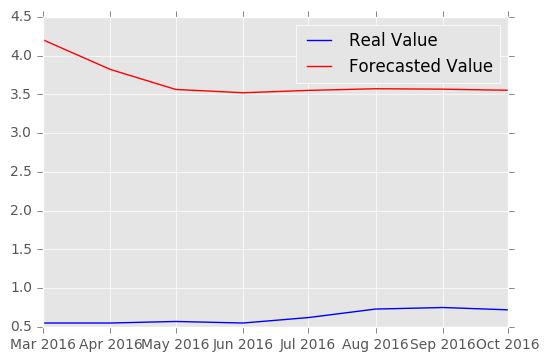

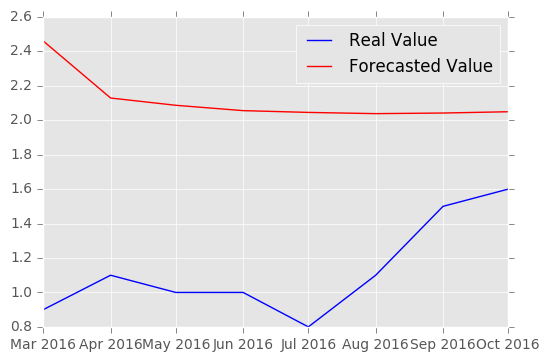

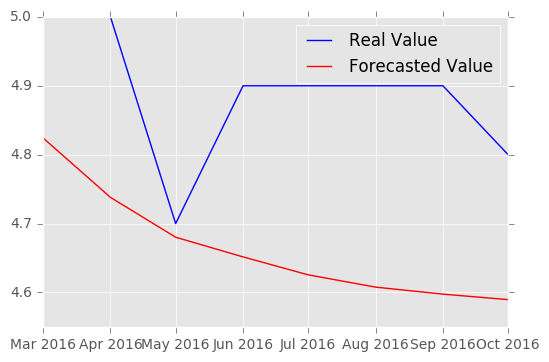

In [80]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])